In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [3]:
!pwd


/home/akarimzadeh/code/antoninolm/climate_change_project


In [4]:
# Define file path
file_path = "raw_data/Q_13_previous-1950-2023_RR-T-Vent.csv.gz"

# Read the CSV file
df = pd.read_csv(file_path, compression="gzip", sep=";")

# Display first few rows
df.head()


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620701,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620702,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620703,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620704,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620705,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering

In [5]:
# Count the number of unique weather station names
df["NOM_USUEL"].nunique()

112

In [6]:
df["date"] = pd.to_datetime(df["AAAAMMJJ"], format="%Y%m%d")

### I add all T columns and rain Columns in case if we want later do another modeling

In [7]:
df = df[["NOM_USUEL","TN", "TX", "TNTXM", "TM", "TNSOL", "QTNSOL","RR", "date"]]

# Display the first few rows to verify the selection
print(df.head())


       NOM_USUEL  TN  TX  TNTXM  TM  TNSOL  QTNSOL   RR       date
0  AIX-PUYRICARD NaN NaN    NaN NaN    NaN     NaN  0.0 1962-07-01
1  AIX-PUYRICARD NaN NaN    NaN NaN    NaN     NaN  0.0 1962-07-02
2  AIX-PUYRICARD NaN NaN    NaN NaN    NaN     NaN  0.0 1962-07-03
3  AIX-PUYRICARD NaN NaN    NaN NaN    NaN     NaN  0.0 1962-07-04
4  AIX-PUYRICARD NaN NaN    NaN NaN    NaN     NaN  0.0 1962-07-05


In [8]:
# Ensure that 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index
df.set_index('date', inplace=True)

# Filter the data to only include dates from 1950 to 2023
df_filtered = df[(df.index.year >= 1950) & (df.index.year <= 2023)]

# Find stations that have data in this period
stations_with_data = df_filtered["NOM_USUEL"].unique()

# Check if any station has data for the full period from 1950 to 2023
station_data_1950_2023 = {}
for station in stations_with_data:
    station_data = df_filtered[df_filtered["NOM_USUEL"] == station]
    min_year = station_data.index.year.min()
    max_year = station_data.index.year.max()

    # If the station has data from 1950 to 2023, add it to the dictionary
    if min_year <= 1950 and max_year >= 2023:
        station_data_1950_2023[station] = station_data

# Display the station(s) with data from 1950 to 2023
for station, data in station_data_1950_2023.items():
    print(f"Station {station} has data from 1950 to 2023.")
    print(data.head())  # Display the first few rows of data for that station


Station AUBAGNE has data from 1950 to 2023.
           NOM_USUEL  TN  TX  TNTXM  TM  TNSOL  QTNSOL   RR
date                                                       
1950-01-01   AUBAGNE NaN NaN    NaN NaN    NaN     NaN  0.0
1950-01-02   AUBAGNE NaN NaN    NaN NaN    NaN     NaN  0.0
1950-01-03   AUBAGNE NaN NaN    NaN NaN    NaN     NaN  0.0
1950-01-04   AUBAGNE NaN NaN    NaN NaN    NaN     NaN  0.0
1950-01-05   AUBAGNE NaN NaN    NaN NaN    NaN     NaN  0.0
Station BEC DE L AIGLE has data from 1950 to 2023.
                 NOM_USUEL   TN    TX  TNTXM  TM  TNSOL  QTNSOL   RR
date                                                                
1950-01-01  BEC DE L AIGLE  8.4  13.6   11.0 NaN    NaN     NaN  0.0
1950-01-02  BEC DE L AIGLE  4.6  12.0    8.3 NaN    NaN     NaN  0.0
1950-01-03  BEC DE L AIGLE  5.0  11.0    8.0 NaN    NaN     NaN  0.0
1950-01-04  BEC DE L AIGLE  7.0  12.2    9.6 NaN    NaN     NaN  0.0
1950-01-05  BEC DE L AIGLE  7.0  13.4   10.2 NaN    NaN     NaN  0.0
St

In [9]:
df_aubagne= df[df["NOM_USUEL"] == "AUBAGNE"]

In [10]:
df_aubagne.head()

,NOM_USUEL,TN,TX,TNTXM,TM,TNSOL,QTNSOL,RR
date,,,,,,,,
1950-01-01,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-02,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-03,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-04,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-05,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [11]:
df_aubagne.tail()

,NOM_USUEL,TN,TX,TNTXM,TM,TNSOL,QTNSOL,RR
date,,,,,,,,
2023-12-27,AUBAGNE,-0.6,17.2,8.3,6.6,-3.5,9.0,0.2
2023-12-28,AUBAGNE,3.7,16.1,9.9,10.5,0.7,9.0,0.0
2023-12-29,AUBAGNE,5.9,15.5,10.7,9.6,3.3,9.0,0.2
2023-12-30,AUBAGNE,2.9,17.3,10.1,9.2,1.0,9.0,0.2
2023-12-31,AUBAGNE,7.6,13.9,10.8,10.9,5.0,9.0,0.0


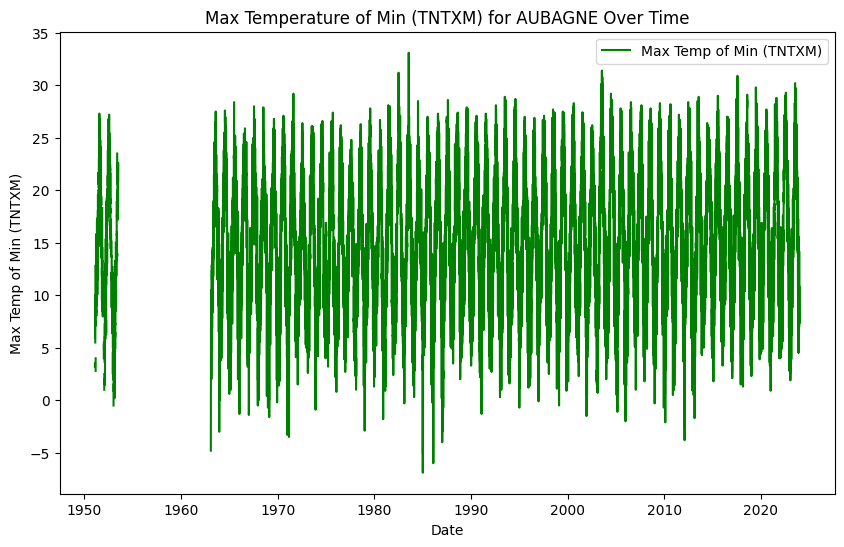

In [12]:
df_aubagne = df_aubagne.sort_index()

# Plot the data for "TNTXM"
plt.figure(figsize=(10, 6))
plt.plot(df_aubagne.index, df_aubagne["TNTXM"], label="Max Temp of Min (TNTXM)", color="green")

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Max Temp of Min (TNTXM)')
plt.title('Max Temperature of Min (TNTXM) for AUBAGNE Over Time')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [13]:
df_aubagne.isnull().sum()

NOM_USUEL        0
TN            4933
TX            4932
TNTXM         4933
TM           17203
TNSOL        17444
QTNSOL       17435
RR              34
dtype: int64

In [14]:
nan_rows = df_aubagne.loc[df_aubagne["TNTXM"].isnull()]

# Display the rows with NaN values in the 'TNTXM' column
nan_rows

,NOM_USUEL,TN,TX,TNTXM,TM,TNSOL,QTNSOL,RR
date,,,,,,,,
1950-01-01,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-01,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-02,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-02,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1950-01-03,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
1963-01-28,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1963-01-29,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.6
1963-01-30,AUBAGNE,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [15]:
# Filter the DataFrame for data after 1964-01-01
df_after_1964 = df_aubagne[df_aubagne.index >= "1964-01-01"]

# Display the filtered data
print(df_after_1964.head())  # You can use .head() to see the first few rows


           NOM_USUEL   TN    TX  TNTXM  TM  TNSOL  QTNSOL   RR
date                                                          
1964-01-01   AUBAGNE  4.2  15.5    9.9 NaN    NaN     NaN  0.0
1964-01-02   AUBAGNE  0.5  14.5    7.5 NaN    NaN     NaN  0.0
1964-01-03   AUBAGNE  0.0  13.0    6.5 NaN    NaN     NaN  0.0
1964-01-04   AUBAGNE  0.0  14.0    7.0 NaN    NaN     NaN  0.0
1964-01-05   AUBAGNE -3.5  13.0    4.8 NaN    NaN     NaN  0.0


In [16]:
df =df_after_1964

## Data Cleaning

### NAN value will be replaced with the values the day after.

In [17]:
# Forward fill missing values
df["TNTXM"] = df["TNTXM"].fillna(method='ffill')


/tmp/ipykernel_110792/159125330.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["TNTXM"] = df["TNTXM"].fillna(method='ffill')
/tmp/ipykernel_110792/159125330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TNTXM"] = df["TNTXM"].fillna(method='ffill')


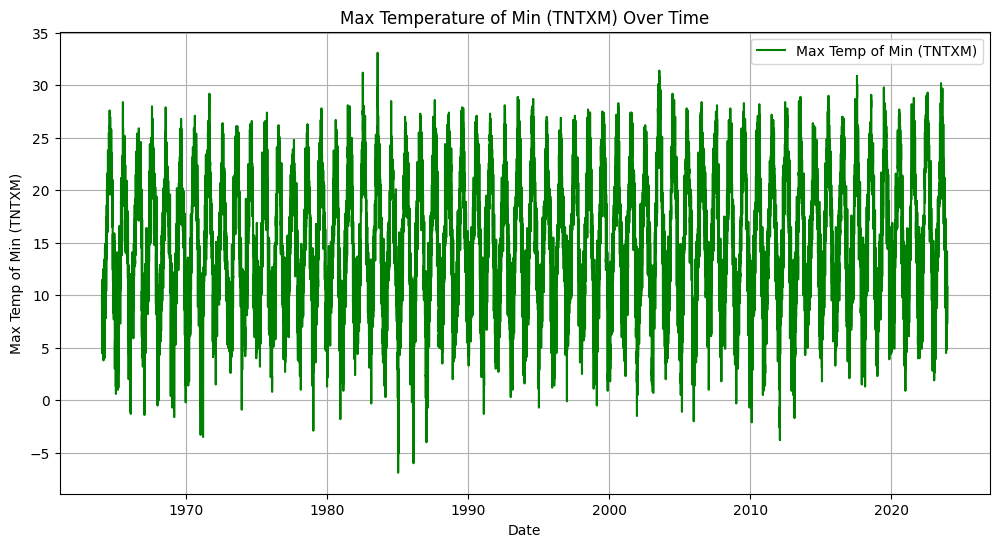

In [18]:
# Plotting the 'TNTXM' column over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["TNTXM"], label="Max Temp of Min (TNTXM)", color="green")
plt.xlabel('Date')
plt.ylabel('Max Temp of Min (TNTXM)')
plt.title('Max Temperature of Min (TNTXM) Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
df["TNTXM"].isnull().sum()


np.int64(0)

## Spiliting Data Set

In [21]:
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train, test = df[:train_size], df[train_size:]

### I do not think finding outlier is necessary because it does not seem like being an outlier but how ever it can be find following and it can be remove by the uncommenting next next row:

In [22]:
from scipy.stats import zscore

# Apply Z-score normalization on the training data for 'TNTXM' column
train['TNTXM_zscore'] = zscore(train['TNTXM'])

# Define a threshold for detecting outliers
threshold = 3  # Values with z-score > 3 or < -3 are considered outliers

# Find outliers based on the Z-score threshold
outliers_train = train[train['TNTXM_zscore'].abs() > threshold]

# Display the outliers
print(outliers_train)

           NOM_USUEL    TN   TX  TNTXM  TM  TNSOL  QTNSOL   RR  TNTXM_zscore
date                                                                        
1985-01-07   AUBAGNE  -9.1 -0.4   -4.8 NaN    NaN     NaN  0.5     -3.046302
1985-01-08   AUBAGNE  -9.5 -4.2   -6.9 NaN    NaN     NaN  0.0     -3.373809
1985-01-09   AUBAGNE -11.5  0.9   -5.3 NaN    NaN     NaN  0.0     -3.124279
1985-01-14   AUBAGNE  -8.0 -2.2   -5.1 NaN    NaN     NaN  0.0     -3.093088
1986-02-10   AUBAGNE -10.0 -2.0   -6.0 NaN    NaN     NaN  0.0     -3.233448


/tmp/ipykernel_2469/287524411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TNTXM_zscore'] = zscore(train['TNTXM'])


In [ ]:
#train_cleaned = train[train['TNTXM_zscore'].abs() <= threshold]

### it seems that data is Stationary

In [25]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the training data
adf_test = adfuller(train['TNTXM'])

# Display the test statistic and p-value
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Interpret the result
if adf_test[1] <= 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")


ADF Statistic: -10.134101598306092
p-value: 8.761382072901383e-18
The series is stationary (reject H0).


### and it is not nessary to decompose trend and seasonality!

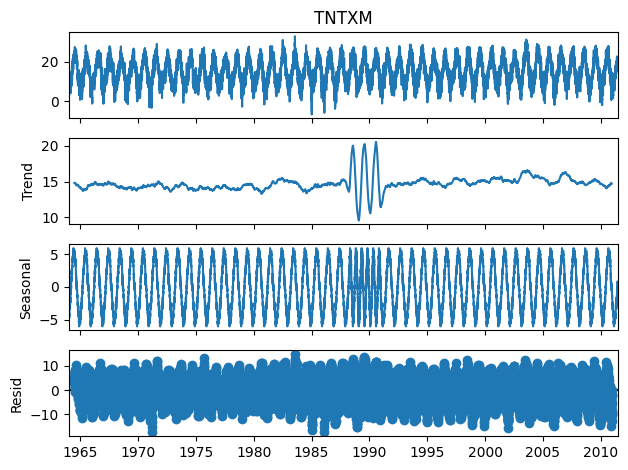

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assume the frequency is set correctly, or you can set it explicitly: df = df.asfreq('D') (daily data)
decomp_train_add = seasonal_decompose(train['TNTXM'], model="additive", period=365)  # assuming yearly seasonality

# You can now examine the trend, seasonal, and residual components for training data
decomp_train_add.plot()
plt.show()